<a href="https://colab.research.google.com/github/OtavioBer/ProjAplicadoIII/blob/OtavioBer-patch-1/Modelo_Recomendacao_Livros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

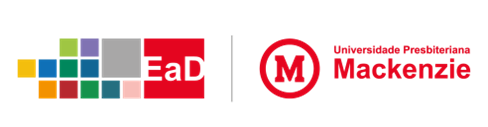

#<font color=blue>Projeto Aplicado III - Modelo de Recomendação de Livros

CURSO: Tecnologia em Ciências de Dados

SEMESTRE: 4º

COMPONENTE CURRICULAR / TEMA: Projeto Aplicado III

NOME DO PROFESSOR: THIAGO DONIZETTI DOS SANTOS

INTEGRANTES E TIA:

1. Caroline Ribeiro Ferreira - 10408052
2. Lais César Fonseca - 10407066
3. Leonardo dos Reis Olher – 10407752
4. Liliane Gonçalves de Brito Ferraz - 10407087
5. Múcio Emanuel Feitosa Ferraz Filho - 10218691
6. Otavio Bernardo Scandiuzzi - 10407867

##<font color=blue>OBJETIVO

Implementar um sistema de recomendação de livros usando análise de dados e aprendizado de máquina, explorando diferentes abordagens para recomendação com base em características dos livros e preferências dos usuários.
Passando por etapas de tratamento dos dados, técnica do modelo, prova de conceito e a forma de avaliação do desempenho.

## 1. Importanto Bibliotecas e Dados

In [ ]:
# Importando bibliotecas e pacotes a serem utilizados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Image, display, HTML
import warnings; warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Verificar o nível de processamento do GPU
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

False


In [ ]:
# CARREGAR OS DADOS DE USUARIOS, CLASSIFICAÇÃO E LIVROS
users = pd.read_csv("/content/drive/My Drive/Projeto Aplicado III/BX-Users.csv", encoding="ISO-8859-1", sep=";")
ratings = pd.read_csv("/content/drive/My Drive/Projeto Aplicado III/BX-Book-Ratings.csv", encoding="ISO-8859-1", sep=";")
books = pd.read_csv("/content/drive/My Drive/Projeto Aplicado III/BX_Books.csv", encoding="ISO-8859-1", sep=";")

## 2. Tratamento e Limpeza dos Dados

Realizar a limpeza, pré-processamento e transformação dos dados brutos em um formato adequado para análise, incluindo remoção de duplicidades e/ou valores ausentes e adequação de variáveis categóricas.

In [ ]:
# SEPARAR PAIS DO LOCATION
users['Country'] = users['Location'].apply(lambda x: x.split(', ')[-1])

# UNIR BASES
df = ratings\
    .merge(users, how='inner', on='User-ID')\
    .merge(books, how='inner', on='ISBN')

# LIMPEZA DE DADOS
df = df\
    .dropna()\
    .drop_duplicates()\
    .drop(['Location','Image-URL-M','Image-URL-L'], axis=1)

# FILTRAR COLUNAS UTILIZADAS NO MODELO
cols = ['User-ID','ISBN','Book-Author','Year-Of-Publication','Publisher','Country','Age','Book-Rating']
avaliacoes = df[cols]
avaliacoes.reset_index(drop=True, inplace=True)

## 3. Implementação do Modelo

O modelo de recomendação é implementado usando redes neurais profundas (DNN). Ele usa embeddings para representar usuários e livros, que são aprendidos durante o treinamento.

In [ ]:
# MODELO DE RECOMENDAÇÃO
class ModeloRecomendacao(nn.Module):

    def __init__(self, ns, embedding_dim):

        super().__init__()
        self.user         = nn.Embedding(ns[0], embedding_dim)
        self.book         = nn.Embedding(ns[1], embedding_dim)
        self.autor        = nn.Embedding(ns[2], embedding_dim)
        self.year         = nn.Embedding(ns[3], embedding_dim)
        self.publisher    = nn.Embedding(ns[4], embedding_dim)
        self.country      = nn.Embedding(ns[5], embedding_dim)
        self.age          = nn.Embedding(ns[6], embedding_dim)

        self.layers       = nn.Sequential(

            nn.Linear(embedding_dim, 6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.ReLU(),
            nn.Linear(3, 1)

        )


    def forward(self, user, book, autor, year, publisher, country, age):

        user_       = self.user(user.long())
        book_       = self.book(book.long())
        autor_      = self.autor(autor.long())
        year_       = self.year(year.long())
        publisher_  = self.publisher(publisher.long())
        country_    = self.country(country.long())
        age_        = self.age(age.long())
        x           = torch.cat([user_, book_, age_, autor_, year_, publisher_, country_], dim=1)
        output      = self.layers(x)
        return output


# TRANSFORMAR DF EM TENSORES
class AvaliacoesDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        X = self.data.iloc[i, :-1].values
        Y = self.data.iloc[i, -1]

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        return X, Y

# CODIFICAR DADOS
def encoder_df(df):
    enc = {}
    df_enc = {}

    for col in df.columns.tolist():
        enc[col] = LabelEncoder().fit(df[col])
        df_enc[col] = enc[col].transform(df[col])

    df_enc = pd.DataFrame(df_enc)
    return enc, df_enc


# CODIFICAR PREDIÇÃO
def predict_encoder(df, enc):

    predict_enc = {}

    for col in df.columns.tolist():

        try:
            predict_enc[col] = enc[col].transform(df[col])

        except:
            continue

    return pd.DataFrame(predict_enc)

A implantação deste código visa treinar o modelo para prever a preferência de um usuário por um livro com base em características.

In [ ]:
# DEVICE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CODIFICAR DADOS
enc, df_enc = encoder_df(avaliacoes)

# SPLIT TREINO TESTE
train, test = train_test_split(df_enc, test_size=.2)

# HIPERPAMETROS
ns = []
for col in cols:
    ns.append(len(enc[col].classes_))
embedding_dim = 14
lr=1e-3
load_checkpoint = False

# Modelo de Recomendação
model = ModeloRecomendacao(ns, embedding_dim).to(device)

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Load Model
if load_checkpoint:
    loaded = torch.load('model.pth.tar')
    model.load_state_dict(loaded['state_dict'])
    optimizer.load_state_dict(loaded['optimizer'])


# Mean Squared Error
lossfunc = nn.MSELoss()

# DataSet
train_dataset = AvaliacoesDataset(train)
test_dataset = AvaliacoesDataset(test)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

## 4. Prova de Conceito (PoC)

O modelo é treinado utilizando um conjunto de dados que consiste em avaliações de usuários sobre livros. Durante o treinamento, o modelo aprende a prever a avaliação que um usuário daria a um livro específico com base em várias características do livro e do usuário.

In [ ]:
# TREINO MODELO
epochs=101

for epoch in range(epochs):
    train_loss = 0.0

    for x, y in train_dataloader:
        # X
        user        = torch.Tensor(x[:,0]).float().unsqueeze(1).to(device)
        book        = torch.Tensor(x[:,1]).float().unsqueeze(1).to(device)
        autor       = torch.Tensor(x[:,2]).float().unsqueeze(1).to(device)
        year        = torch.Tensor(x[:,3]).float().unsqueeze(1).to(device)
        publisher   = torch.Tensor(x[:,4]).float().unsqueeze(1).to(device)
        country     = torch.Tensor(x[:,5]).float().unsqueeze(1).to(device)
        age         = torch.Tensor(x[:,6]).float().unsqueeze(1).to(device)
        # y
        rating      = torch.Tensor(y).float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        output = model.forward(user, book, autor, year, publisher, country, age).to(device).sum(dim=1)
        loss = lossfunc(output, rating)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if epoch % 5 == 0:
        checkpoint = {'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
        torch.save(checkpoint, 'model.pth.tar')
        print(f'Epochs: {epoch:>10} | Train Loss: {train_loss/len(train_dataloader):>6.2f}')

Epochs:          0 | Train Loss:  15.07
Epochs:          5 | Train Loss:  10.26
Epochs:         10 | Train Loss:   8.48
Epochs:         15 | Train Loss:   7.62
Epochs:         20 | Train Loss:   7.19
Epochs:         25 | Train Loss:   6.97
Epochs:         30 | Train Loss:   6.85
Epochs:         35 | Train Loss:   6.78
Epochs:         40 | Train Loss:   6.73
Epochs:         45 | Train Loss:   6.70
Epochs:         50 | Train Loss:   6.67
Epochs:         55 | Train Loss:   6.65
Epochs:         60 | Train Loss:   6.64
Epochs:         65 | Train Loss:   6.62
Epochs:         70 | Train Loss:   6.61
Epochs:         75 | Train Loss:   6.60
Epochs:         80 | Train Loss:   6.59
Epochs:         85 | Train Loss:   6.58
Epochs:         90 | Train Loss:   6.58
Epochs:         95 | Train Loss:   6.57
Epochs:        100 | Train Loss:   6.57


## 5. Avaliação de Desempenho do Modelo

O desempenho do modelo é avaliado usando a métrica de erro quadrático médio (MSE) calculada sobre um conjunto de dados de teste separado. Quanto menor o MSE, melhor é o desempenho do modelo em prever as avaliações dos usuários.

In [ ]:
# AVALIAÇÃO DO MODELO
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_dataloader:
        # X
        user        = torch.Tensor(x[:,0]).float().unsqueeze(1).to(device)
        book        = torch.Tensor(x[:,1]).float().unsqueeze(1).to(device)
        autor       = torch.Tensor(x[:,2]).float().unsqueeze(1).to(device)
        year        = torch.Tensor(x[:,3]).float().unsqueeze(1).to(device)
        publisher   = torch.Tensor(x[:,4]).float().unsqueeze(1).to(device)
        country     = torch.Tensor(x[:,5]).float().unsqueeze(1).to(device)
        age         = torch.Tensor(x[:,6]).float().unsqueeze(1).to(device)
        # y
        rating      = torch.Tensor(y).float().unsqueeze(1).to(device)
        # output
        output      = model.forward(user, book, autor, year, publisher, country, age).to(device).sum(dim=1)
        test_loss  += lossfunc(output, rating).item()

print(f'Test Loss: {test_loss/len(test_dataloader):2f}')

Test Loss: 14.482713


## 5. Implemetação do Modelo

A implementação deste código visa a recomendação de livros para um usuário específico, apresento o resultado de indicação de livros que esteja de acordo com a sua preferência.

In [ ]:
# 1º USUARIO QUE TERÁ RECOMENDAÇÃO
user_id = 28523
n_recomendacoes = 5

assert user_id in avaliacoes['User-ID'].unique().tolist()

# FILTRAR USUARIO NA BASE
user_filter = users[users['User-ID'] == user_id].iloc[0].tolist()

# RECOMENDAR LIVRO
predict_data = books[['Book-Title','ISBN','Image-URL-S','Book-Author','Year-Of-Publication','Publisher']].drop_duplicates()

# APENAS LIVROS TREINADOS PELO MODELO
predict_data = predict_data[predict_data['ISBN'].isin(avaliacoes['ISBN'].unique().tolist())]

# INCLUIR DADOS DO USER EM TODAS AS LINHAS
predict_data['User-ID'] = user_id
predict_data['Country'] = user_filter[3]
predict_data['Age'] = user_filter[2]

# REMOVER LIVROS JÁ AVALIDADOS PELO USUARIO
books_list = avaliacoes[avaliacoes['User-ID'] == user_id]['ISBN']
predict_data = predict_data[~predict_data['ISBN'].isin(books_list)].copy()
predict_encoded = predict_encoder(predict_data, enc)

# COLUNAS
cols_pred = cols.copy()
cols_pred.remove('Book-Rating')
predict_encoded = predict_encoded[cols_pred]
predict_encoded['y dummy'] = 0

# DATASET
predict_dataset = AvaliacoesDataset(predict_encoded)

# DATALOADER
predict_dataloader = DataLoader(predict_dataset)

# RECOMENDAÇÃO DO MODELO
model.eval()
outputs = []
with torch.no_grad():
    for x, y in predict_dataloader:
        # X
        user        = torch.Tensor(x[:,0]).float().unsqueeze(1).to(device)
        book        = torch.Tensor(x[:,1]).float().unsqueeze(1).to(device)
        autor       = torch.Tensor(x[:,2]).float().unsqueeze(1).to(device)
        year        = torch.Tensor(x[:,3]).float().unsqueeze(1).to(device)
        publisher   = torch.Tensor(x[:,4]).float().unsqueeze(1).to(device)
        country     = torch.Tensor(x[:,5]).float().unsqueeze(1).to(device)
        age         = torch.Tensor(x[:,6]).float().unsqueeze(1).to(device)
        # output
        output      = model.forward(user, book, autor, year, publisher, country, age).to(device).sum(dim=1).item()
        outputs.append(output)

predict_data['PREDICT RATING'] = outputs

recomendacao = predict_data.sort_values(by='PREDICT RATING', ascending=False)[:n_recomendacoes]
recomendacao

,Book-Title,ISBN,Image-URL-S,Book-Author,Year-Of-Publication,Publisher,User-ID,Country,Age,PREDICT RATING
188520,Human Diversity In Education: An Integrative A...,0070150672,http://images.amazon.com/images/P/0070150672.0...,Kenneth Cushner,1996,McGraw-Hill Companies,28523,usa,24.0,11.967375
169984,The Swiftness of Crows: Poems of Two Continents,0934910065,http://images.amazon.com/images/P/0934910065.0...,Nancy Wall,1999,Moon Pony Press,28523,usa,24.0,11.206444
129052,"The Protocols (TCP/IP Illustrated, Volume 1)",0201633469,http://images.amazon.com/images/P/0201633469.0...,W. Richard Stevens,1994,Addison-Wesley Professional,28523,usa,24.0,11.119248
188361,"The Facts of Life: Stories, 1940-1949 (His the...",0876853564,http://images.amazon.com/images/P/0876853564.0...,Paul Goodman,1979,David R Godine Pub,28523,usa,24.0,10.700144
215187,Bury Me With Soldiers: One Grunt's Honest Stor...,1410706575,http://images.amazon.com/images/P/1410706575.0...,C. W. Standiford,2003,Authorhouse,28523,usa,24.0,10.636484


In [ ]:
#Exibir a lista de recomendação com as imagens dos livros.
n = 1
for  _, row in recomendacao.iterrows():

    title = f'{n} - Titulo: {row["Book-Title"]}'
    isbn = f'ISBN: {row["ISBN"]}'
    url = row['Image-URL-S']
    display(HTML(f'<div><h3>{title}</h3><h4>{isbn}</h4><a href="{url}" target="_blank"><img src="{url}"></a></div>'))
    n+=1